<a href="https://colab.research.google.com/github/EdonFetaji/DataScience/blob/main/labs/Lab4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [3]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
!pip install transformers

In [5]:
import pandas as pd
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is **exceptional** based on its review.

## The Wine Reviews Dataset

Load the dataset using the `datasets` library.

In [39]:
data =load_dataset('csv',data_files = 'wine-reviews.csv')


Generating train split: 0 examples [00:00, ? examples/s]

## Target Extraction
Extract the target **exceptional** for each wine review. If some wine has at least 90 points it is considered **exceptional**.

In [40]:
data = data.map(lambda x : {**x ,'label' : 1 if x['points']>=90 else 0} )

Map:   0%|          | 0/129971 [00:00<?, ? examples/s]

In [69]:
data

DatasetDict({
    train: Dataset({
        features: ['description', 'points', 'label'],
        num_rows: 129971
    })
})

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [41]:
data= data.rename_column('description','text')

data= data.remove_columns(column_names=['points'])

data


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 129971
    })
})

In [42]:
train_test_split = data['train'].train_test_split(test_size=0.2, seed=69)

In [43]:
train_test_split

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 103976
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25995
    })
})

In [44]:
train_val_split = train_test_split['train'].train_test_split(test_size=0.25, seed=69)
train_val_split

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 77982
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25994
    })
})

In [45]:
final_dataset = datasets.DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': train_test_split['test']
})
final_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 77982
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 25994
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25995
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [46]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [43]:
inputs = tokenizer("Hello, friend!", padding=True, truncation=True, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 7592, 1010, 2767,  999,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [47]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=128, return_tensors="pt")



In [48]:
tokenized_dataset = final_dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/77982 [00:00<?, ? examples/s]

Map:   0%|          | 0/25994 [00:00<?, ? examples/s]

Map:   0%|          | 0/25995 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 77982
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25994
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25995
    })
})

In [49]:
tokenized_dataset = tokenized_dataset.remove_columns(['text'])
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 77982
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25994
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25995
    })
})

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [50]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# freeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

Define the traning parameters using the `TrainingArguments` class.

In [52]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    weight_decay=0.01,
    save_steps=2000,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_dir="./logs",
    logging_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="tensorboard"
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Define the training using the `Trainer` class.

In [53]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # For classification, get the index of the max logit
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [54]:
from transformers import Trainer, BertForSequenceClassification

In [55]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


<ipython-input-55-1eb325347c94>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fine-tune (train) the pre-trained lanugage model.

In [56]:
trainer.train()


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1000,0.551100,0.496805,0.759368,0.710936,0.625063,0.665239
2000,0.504000,0.477624,0.768062,0.761701,0.572865,0.653923
3000,0.482100,0.461119,0.778064,0.724312,0.677763,0.700265
4000,0.472000,0.454619,0.780103,0.756462,0.626974,0.685658
5000,0.471600,0.448365,0.784912,0.753850,0.649904,0.698029
6000,0.467100,0.444516,0.788259,0.733312,0.701599,0.717105
7000,0.465000,0.442460,0.788105,0.749690,0.669617,0.707395
8000,0.462200,0.442642,0.786912,0.771919,0.628683,0.692977
9000,0.469100,0.441944,0.788105,0.772119,0.632807,0.695556
10000,0.463100,0.439362,0.789605,0.760723,0.656442,0.704745


TrainOutput(global_step=14622, training_loss=0.4741611180692247, metrics={'train_runtime': 4450.5055, 'train_samples_per_second': 52.566, 'train_steps_per_second': 3.285, 'total_flos': 1.538844473931264e+16, 'train_loss': 0.4741611180692247, 'epoch': 3.0})

Use the trained model to make predictions for the test set.

In [57]:
test_results = trainer.evaluate(tokenized_dataset["test"])
test_results

{'eval_loss': 0.4364546239376068,
 'eval_accuracy': 0.7928832467782266,
 'eval_precision': 0.7501987055751107,
 'eval_recall': 0.6748033908691655,
 'eval_f1': 0.7105065060759221,
 'eval_runtime': 183.9855,
 'eval_samples_per_second': 141.288,
 'eval_steps_per_second': 8.832,
 'epoch': 3.0}

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [59]:
true_labels = tokenized_dataset["test"]["label"]

In [60]:
predictions = trainer.predict(tokenized_dataset["test"]).predictions
predicted_labels = predictions.argmax(axis=-1)

In [61]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

In [62]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Not Exceptional", "Exceptional"]))

Accuracy: 0.7928832467782266
Precision: 0.7501987055751107
Recall: 0.6748033908691655
F1 Score: 0.7105065060759221

Classification Report:
                 precision    recall  f1-score   support

Not Exceptional       0.81      0.86      0.84     16204
    Exceptional       0.75      0.67      0.71      9791

       accuracy                           0.79     25995
      macro avg       0.78      0.77      0.77     25995
   weighted avg       0.79      0.79      0.79     25995



# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify wine reviews as **exceptional** or not. Use TF-IDF vectorization to convert text into numerical features and train a logistic regression. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. Analyze the texts to find the most influential words or phrases associated with the **exceptional** wines. Use the coefficients from the logistic regression trained on TF-IDF features to identify the top positive and negative keywords for **exceptional** wines. Present these keywords in a simple table or visualization (e.g., bar chart).

In [6]:
df = pd.read_csv('/content/wine-reviews.csv')
df.sample(10)

,description,points
125296,"This chunky, fruity wine is full bodied and ri...",94
99934,"Slightly pickled and brambly on the nose, and ...",84
10758,"Saffredi is a beautiful wine, worthy of member...",94
111659,"Rich and seductive aromas of black cherry, van...",92
57721,"This bottling, which is bolstered by 9% Malbec...",91
50296,Dusty strawberry and cherry aromas are hollow ...,84
119163,The wine smells of over-ripe fruit and this se...,83
14044,This Amarone shows nearly overripe black fruit...,87
96109,"Shows the classic Kunde signature of pure, int...",87
47678,Aromas of stalky berries are bold but a touch ...,89


In [9]:
df['exceptional'] = df['points'].map(lambda x : 1 if x>=90 else 0)
df.drop(columns=['points'],axis=1,inplace=True)
df.sample(10)

,description,exceptional
85656,Ritratti Pinot Nero is a flush and pristine ex...,0
91714,This inviting Pinot is broadly ripe and fully ...,0
49141,"Firm, dry tannins mark this Merlot, and it has...",0
31398,This structured rosato from northern Italy is ...,0
66690,"Sharp and tangy, this assertive wine shows a w...",0
63390,"Though not labeled as such, this is single vin...",0
13396,"The blend is 59% Merlot, 33% Syrah, and 8% Cab...",0
112653,"Dark for a rosé and rather full-bodied, this b...",0
97838,"Tire rubber, heat and funky, oak-based spice a...",0
68021,You don't get sun-ripened Merlot from Monterey...,0


In [10]:
train_x,test_x,train_y,test_y = train_test_split(df.description,df.exceptional,test_size=0.2,shuffle=True,random_state = 69)

In [25]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [12]:
pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(stop_words='english',use_idf=True)),
    ('model',LogisticRegression())
])

In [13]:
pipeline.fit(train_x,train_y)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('model', LogisticRegression())])

In [14]:
pred_y = pipeline.predict(test_x)

In [16]:
print(classification_report(test_y,pred_y,target_names=["Not Exceptional", "Exceptional"]))

                 precision    recall  f1-score   support

Not Exceptional       0.85      0.89      0.87     16281
    Exceptional       0.81      0.74      0.77      9714

       accuracy                           0.84     25995
      macro avg       0.83      0.82      0.82     25995
   weighted avg       0.84      0.84      0.84     25995



In [17]:
vectorizer = pipeline.named_steps['vectorizer']
model = pipeline.named_steps['model']


In [18]:
coefficients = model.coef_.flatten()
feature_names = vectorizer.get_feature_names_out()

In [19]:
print(coefficients,feature_names)

[-0.54930445 -0.06876335 -0.13151958 ...  0.13217388  0.102421
 -0.05305827] ['000' '01' '02' ... 'ürzig' 'ürziger' 'žilavka']


In [22]:
top_positive_indices = np.argsort(coefficients)[-10:]
top_negative_indices = np.argsort(coefficients)[:10]

In [23]:
top_positive_keywords = [feature_names[i] for i in top_positive_indices]
top_positive_keywords

['complex',
 '2030',
 'beautiful',
 '92',
 '2024',
 '2021',
 '2020',
 '2023',
 '2025',
 '2022']

In [24]:
top_negative_keywords = [feature_names[i] for i in top_negative_indices]
top_negative_keywords

['simple',
 'lacks',
 'straightforward',
 'easygoing',
 'everyday',
 'easy',
 'dimensional',
 'rustic',
 'short',
 'prosecco']

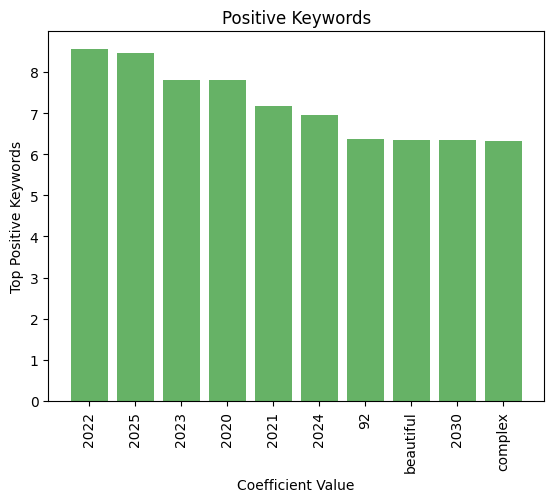

In [36]:

plt.bar(top_positive_keywords[::-1], coefficients[top_positive_indices][::-1], color='green', alpha=0.6)
plt.xlabel('Coefficient Value')
plt.ylabel('Top Positive Keywords')
plt.title('Positive Keywords')
plt.xticks(rotation = 90)
plt.show()




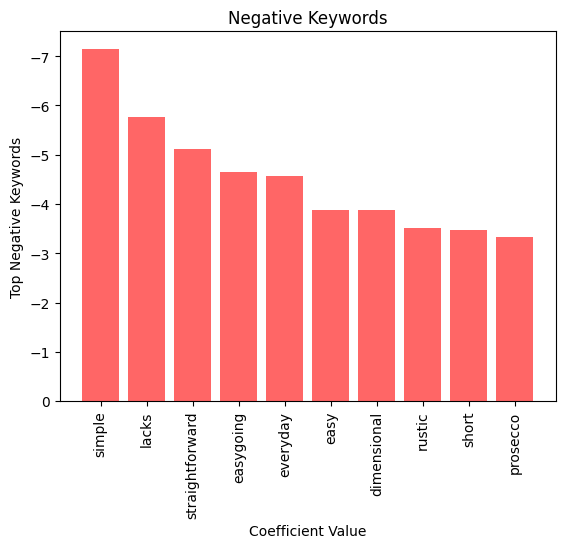

In [38]:

plt.bar(top_negative_keywords, coefficients[top_negative_indices], color='red', alpha=0.6)
plt.xlabel('Coefficient Value')
plt.ylabel('Top Negative Keywords')
plt.title('Negative Keywords')
plt.gca().invert_yaxis()
plt.xticks(rotation = 90)
plt.show()

### **TRYING KNN MODEL**

---



In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
pipeline = Pipeline([
     ('vectorizer',TfidfVectorizer(stop_words='english',use_idf=True)),
     ('model', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
])

In [66]:
pipeline.fit(train_x,train_y)


Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('model', KNeighborsClassifier(metric='euclidean'))])

In [67]:
pred_y = pipeline.predict(test_x)

In [68]:
print(classification_report(test_y,pred_y,target_names=["Not Exceptional", "Exceptional"]))

                 precision    recall  f1-score   support

Not Exceptional       0.75      0.91      0.82     16281
    Exceptional       0.77      0.48      0.59      9714

       accuracy                           0.75     25995
      macro avg       0.76      0.70      0.71     25995
   weighted avg       0.76      0.75      0.74     25995

